# REVIEW THE WHOLE PROCESS WITH TORIN!

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from matplotlib import cm
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

In [2]:
device = torch.device('cuda')

In [3]:
all_data_files = glob('./data/*.pkl')

In [4]:
def clean_data(data):
    data[data == -1] = 0
    data[143:167, 223:247][data[143:167, 223:247] == 0] = 1
    return data 

def resize_data(data):
    im = Image.fromarray(np.uint8(cm.gist_earth(data, alpha=None)*255)[:, :, :3])
    resized_data = np.array(im.resize((112, 76)).convert('L'))
    return resized_data/resized_data.max()

class UpperDiagonalThresholdedLogTransform:
    def __init__(self, nu):
        self.b_1 = (torch.Tensor([1, 1]) / np.sqrt(2))
        self.b_2 = (torch.Tensor([-1, 1]) / np.sqrt(2))
        self.nu = nu

    def __call__(self, dgm):
        if len(dgm) == 0:
            return dgm
        
        self.b_1 = self.b_1.to(dgm.device)
        self.b_2 = self.b_2.to(dgm.device)

        x = torch.mul(dgm, self.b_1.repeat(dgm.size(0), 1))
        x = torch.sum(x, 1).squeeze()
        y = torch.mul(dgm, self.b_2.repeat( dgm.size(0), 1))
        y = torch.sum(y, 1).squeeze()
        i = (y <= self.nu)
        y[i] = torch.log(y[i] / self.nu)*self.nu + self.nu
        ret = torch.stack([x, y], 1)
        return ret

class SeaIceDataset(Dataset):
    
    def __init__(self, seq_len, data_folder='./data/*.pkl', return_dims=False):
        self.seq_len = seq_len
        self.data_files = glob(data_folder)
        self.return_dims = return_dims
        
    def __len__(self):
        return len(self.data_files) - (self.seq_len + 1)
    
    def __getitem__(self, ix):
        X = np.array([resize_data(clean_data(np.array(np.load(d)))) for d in self.data_files[ix:ix+self.seq_len]], dtype=np.float32)
        y = resize_data(clean_data(np.load(self.data_files[ix+self.seq_len+1]))).flatten().astype(np.float32)
        
        if self.return_dims:
            dim0 = [np.load('./barcodes/dim0/{}'.format(d.split('/')[-1].split('.')[0] + '_dim0.npy')) for d in self.data_files[ix:ix+self.seq_len]]
            dim1 = [np.load('./barcodes/dim1/{}'.format(d.split('/')[-1].split('.')[0] + '_dim1.npy')) for d in self.data_files[ix:ix+self.seq_len]]
            return X, dim0, dim1, y
        else:
            return X, y
    
# final = resize_data(clean_data(np.load(all_data_files[-1]))).flatten()
# dataset = SeaIceDataset(3)
# assert(np.allclose(final, dataset[len(dataset)-1][1]))

# Visualize some resized examples

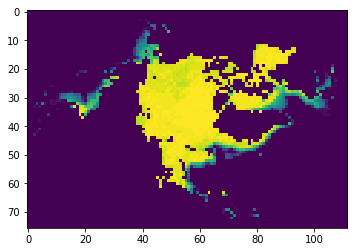

In [5]:
plt.imshow(resize_data(clean_data(np.load(all_data_files[3]))))

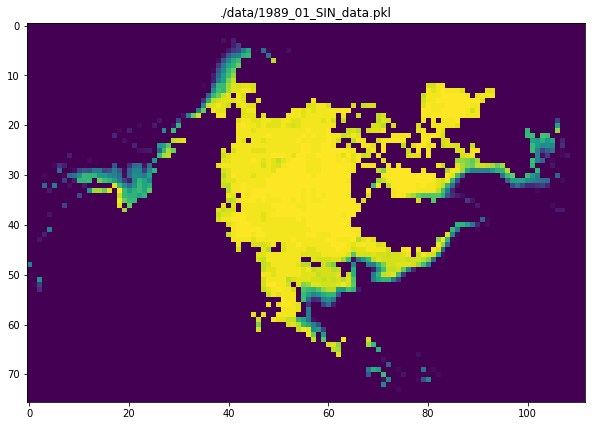

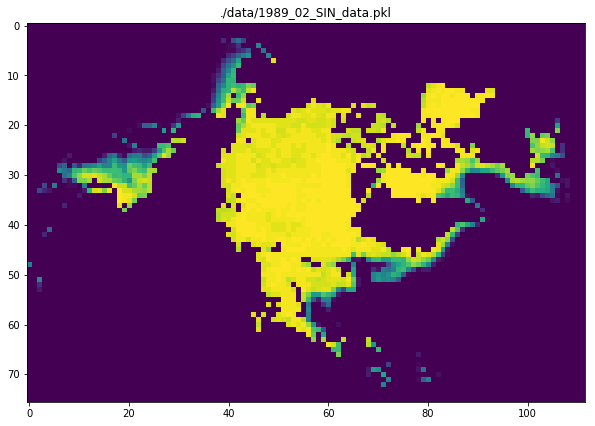

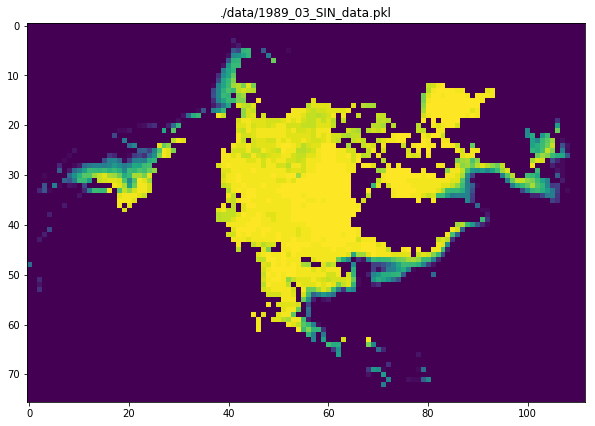

In [6]:
seqs = []
for d in all_data_files[:3]:
    data = clean_data(np.load(d))
    plt.figure(figsize=(10,10))
    plt.title(d)
    plt.imshow(resize_data(data))
    seqs.append(resize_data(data).flatten())

# Examining input data in context of LSTM

In [7]:
class ConvBlock(torch.nn.Module):
    
    def __init__(self):
        super(ConvBlock, self).__init__()
        self.conv_block = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2), # 152
            torch.nn.Conv2d(8, 4, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2), # 76
            torch.nn.Conv2d(4, 2, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Conv2d(2, 1, kernel_size=1),
            torch.nn.ReLU()# 1x38x56
        )
    
    def forward(self, x):
        return self.conv_block(x)

class AutoLSTM(torch.nn.Module):
    
    def __init__(self, encoder, input_dim, batch_size, hidden_dim, seq_length, num_layers, homology=False, N=75):
        super(AutoLSTM, self).__init__()
        
        self.seq_length = seq_length
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.input_size = input_dim
        self.homology = homology
        self.N = N
        self.encoder = encoder
        
        # Add the encoder to the model and turn off gradients for it.
        self.add_module('encoder', encoder)
        encoder.eval()
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        # Generate as many convolutional networks as needed.
#         self.conv_nets = []
#         for ix in range(self.seq_length):
#             cn = ConvBlock()
#             self.conv_nets.append(cn)
#             self.add_module('conv{}'.format(ix+1), cn)
            
        # Increase input for topo signatures.
        if self.homology:
            self.input_size = self.input_size + self.N
            
            self.slayer = SLayer(self.N)
        
        self.lstm = torch.nn.LSTM(self.input_size, self.hidden_dim, num_layers=self.num_layers, batch_first=True)
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.randn(self.num_layers, self.batch_size, self.hidden_dim, device=device),
                torch.randn(self.num_layers, self.batch_size, self.hidden_dim, device=device))
    
    def forward(self, x, dim0=torch.tensor([], device=device), dim1=torch.tensor([], device=device)):
        # X is (batch, seq, w, h)
        # Run inputs throuh conv nets.
        x = torch.cat([self.encoder(x[:, [ix], :, :]) for ix in range(self.seq_length)], dim=1)
        # Flatten out the images.
        x = x.view(self.batch_size, self.seq_length, self.input_size)
        
        # If we have topo features given use them.
        x = torch.cat([x, dim0, dim1])
        
        # Run through the lstm network.
        o, self.hidden = self.lstm(x, self.hidden)     
        return o
    
# class autoencoder(torch.nn.Module):
#     def __init__(self):
#         super(autoencoder, self).__init__()
#         self.encoder = torch.nn.Sequential(
#             torch.nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
#             torch.nn.ReLU(True),
#             torch.nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
#             torch.nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
#             torch.nn.ReLU(True),
#             torch.nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
#         )
#         self.decoder = torch.nn.Sequential(
#             torch.nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
#             torch.nn.ReLU(True),
#             torch.nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
#             torch.nn.ReLU(True),
#             torch.nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
#             torch.nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

class autoencoder(torch.nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, 3,  padding=1),
            torch.nn.BatchNorm2d(16),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.Conv2d(16, 16, 3, padding=1),
            torch.nn.BatchNorm2d(16),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=(2,2)),
            
            torch.nn.Conv2d(16, 8, 3, padding=1),  # b, 8, 3, 3
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(8, 1, 3, padding=1),  # b, 8, 3, 3
            torch.nn.BatchNorm2d(1),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=(2,2))
        )
        self.decoder = nn.Sequential(
            torch.nn.Conv2d(1, 8, 3, padding=1),
            torch.nn.BatchNorm2d(8),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.Conv2d(8, 16, 3, padding=1),
            torch.nn.BatchNorm2d(16),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(16, 16, kernel_size=(2,2), stride=2),
            
            # b, 16, 5, 5
            torch.nn.Conv2d(16, 8, 3, padding=1),
            torch.nn.BatchNorm2d(8),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.Conv2d(8, 8, 3, padding=1),
            torch.nn.BatchNorm2d(8),# b, 16, 10, 10
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(8, 1, kernel_size=(2,2), stride=2),
#             nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
8*3

24

In [9]:
8*6*9

432

In [10]:
seq_length = 3
num_layers = 1
batch_size = 6
hidden_dim = 8512
input_size = 532#9*14
n_epochs = 10

In [11]:
auto = torch.load('autoencoder_paperv4.model')

In [12]:
device = torch.device('cuda')

si_dataset = SeaIceDataset(seq_length)
train_loader = DataLoader(si_dataset, shuffle=True, batch_size=batch_size, num_workers=3, drop_last=True)

model = AutoLSTM(input_dim=input_size, seq_length=seq_length,
                   hidden_dim=hidden_dim, batch_size=batch_size,
                   num_layers=num_layers, encoder=auto.encoder).to(device)

# model = torch.load('good')

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
criterion = torch.nn.MSELoss()

In [13]:
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=0)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

# #instantiate your model here:
# model = UNET().cuda()

# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
# n_epochs = 200
# # Learning rate is reduced after plateauing to stabilize the end of training.
# # use the learning rate scheduler as defined here. Example on how to integrate it to training in
# # https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.1)

# # Setting up BCE loss function.
# pos_weight = torch.FloatTensor([pos_weight]).cuda()
# criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# #train your model here:
# for epoch in range(n_epochs):
#     epoch = epoch + 0
#     print('Epoch ' + str(epoch))
    
#     # Setting to training mode.
#     model.train()
#     losses_rn_mod = []
#     scheduler.step()
    
#     # For each batch.
#     for img, seg, mask in train_loader:
#         # Seeting grad to zero
#         optimizer.zero_grad()
        
#         #putting variables on GPU since model is on GPU
#         img = img.cuda()
#         seg = seg.cuda()
#         mask = mask.cuda()
        
#         # RUnning image through model
#         out_seg = model(img)
        
#         #calculating the losses with the defined criterion
#         loss = criterion(out_seg*mask, seg*mask)
#         loss.backward()
#         optimizer.step()
#         losses_rn_mod.append(loss.item())
#     del img, seg, mask, out_seg, loss
    
#     train_loss = get_score_model(model, train_loader)
#     print("train loss:", str(train_loss), str(np.mean(losses_rn_mod)))
#     val_loss = get_score_model(model, val_loader)
#     print("val loss:" + str(val_loss))  
    
#     # Save the model for possible use later.
#     torch.save(model, './Models/reg_mod/mod_ep-{}_val-{}'.format(epoch, np.mean(val_loss)))

In [14]:
# torch.cuda.empty_cache()

In [15]:
# torch.save(model, 'good')

In [16]:
for epoch in range(n_epochs):
    print("epoch: {}".format(epoch))
    
    model.train()
    train_losses = []
    for ix, (X, y) in enumerate(train_loader):
        # Empty out the grads.
        optimizer.zero_grad()
        
        X = X.to(device)
        y = y.to(device)

        out = model(X)
        
        
#         print("out_shape", out.shape)
#         print("y_shape", y.shape)
        loss = criterion(out[:,-1,:], y)
        loss.backward(retain_graph=True)
        optimizer.step()
        train_losses.append(loss.item())
        
        del out, X, y, loss
    
    print("loss: {}".format(train_losses[-1]))

epoch: 0
loss: 0.05277032405138016
epoch: 1
loss: 0.025055069476366043
epoch: 2
loss: 0.01624862663447857
epoch: 3
loss: 0.011364283040165901
epoch: 4
loss: 0.0188069436699152
epoch: 5


RuntimeError: CUDA out of memory. Tried to allocate 1.15 GiB (GPU 0; 15.90 GiB total capacity; 8.09 GiB already allocated; 1.08 GiB free; 1.36 GiB cached)

In [ ]:
torch.save(model, 'first_automod')

In [36]:
for X,y in train_loader:
    break

In [37]:
preds = model(X.to(device))

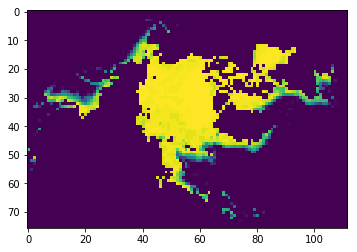

In [38]:
plt.imshow(X[0, 0, :,:])

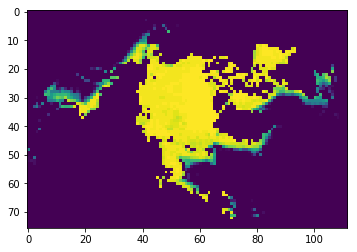

In [39]:
plt.imshow(X[0, 1, :,:])

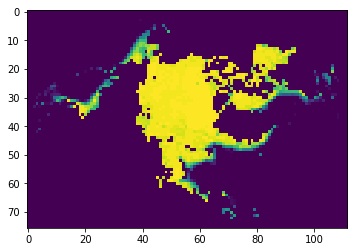

In [40]:
plt.imshow(X[0, 2, :, :])

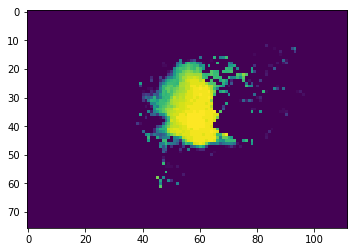

In [41]:
plt.imshow(y[0].detach().numpy().reshape(76, 112))

In [42]:
preds[0,-1, :].cpu().detach().numpy().reshape(76, 112).shape

(76, 112)

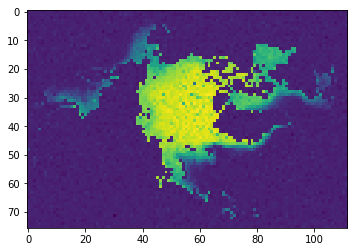

In [49]:
plt.imshow(preds[0,1, :].cpu().detach().numpy().reshape(76, 112))